# Convolutional Autoencoder

Sticking with the CIFAR10 dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

Let's get started by importing our libraries and getting the dataset.

In [57]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
# pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = datasets.CIFAR10(root='data', train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
# # Create training and test dataloaders

# num_workers = 1
# # how many samples per batch to load
# batch_size = 25

# # prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size, False, num_workers)
# test_loader =  torch.utils.data.DataLoader(test_data, batch_size, False, num_workers)

### Visualize the data

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


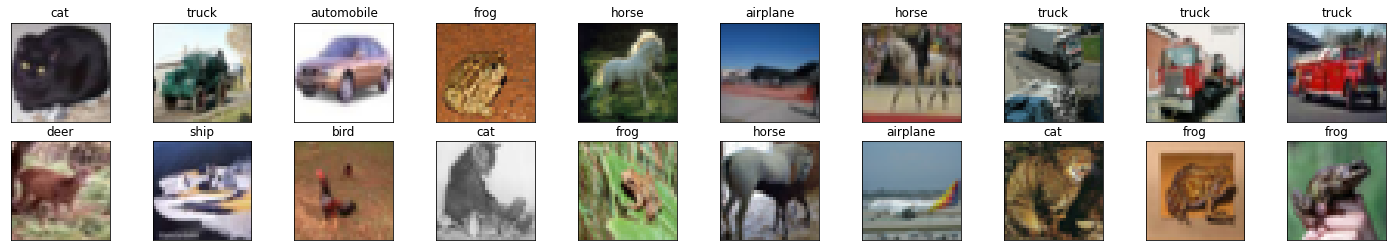

In [67]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

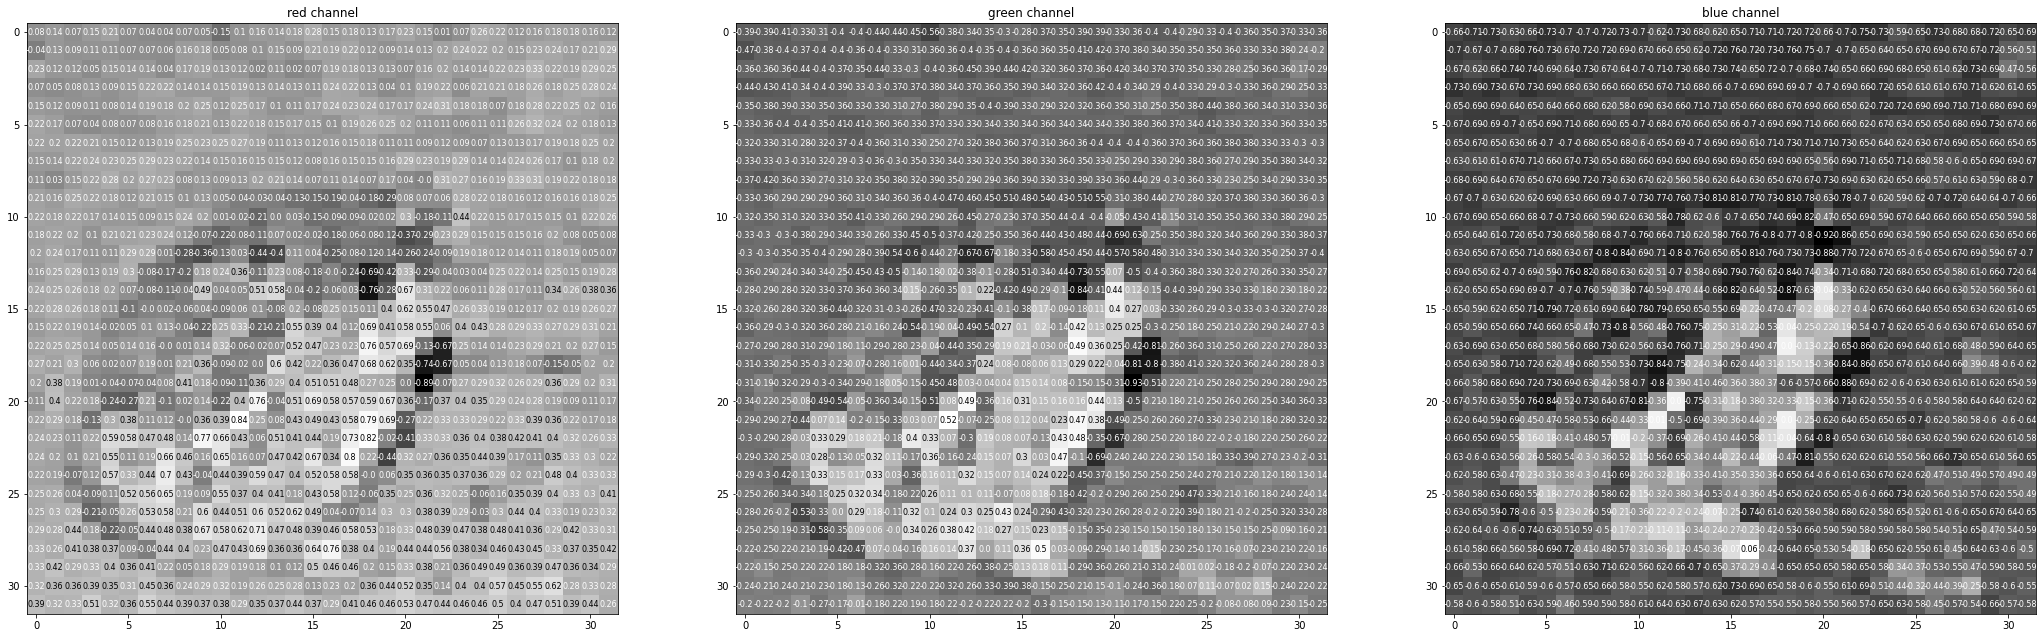

In [68]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 32x32x3 image out from the decoder so we need to work our way back up from the compressed representation.

In [83]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x


# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `BCELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [77]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [84]:
# number of epochs to train the model
n_epochs = 1

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
       
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/venkatakrishnachaitanyanuthalapati/Library/Python/3.8/lib/python/site-packages/torch/nn/functional.py:1806: U

Epoch: 1 	Training Loss: 141.104110


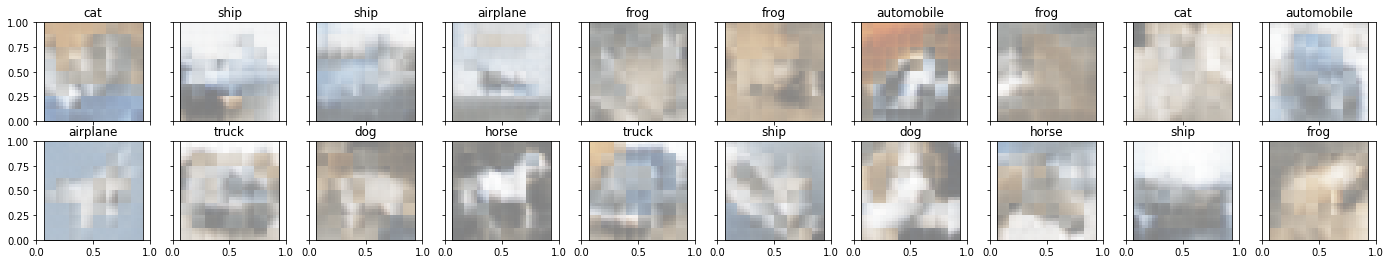

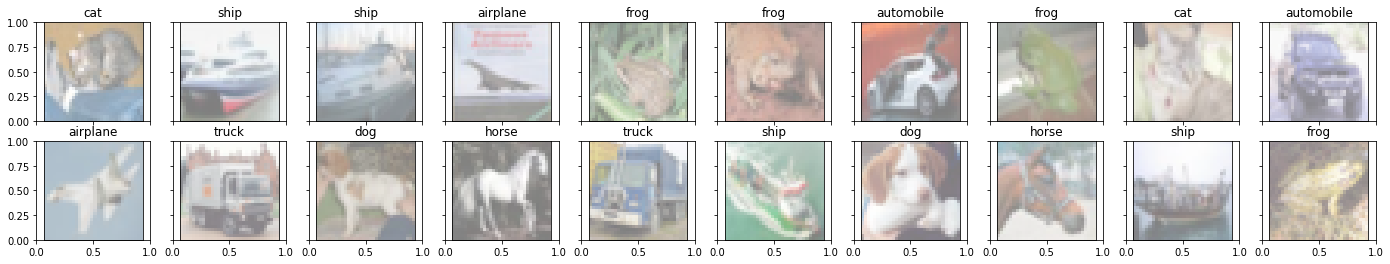

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs

# prep images for display



# output is resized into a batch of iages

# use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])